In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

#!pip install stellargraph

!pip install networkx
import networkx as nx

!pip install scikit-plot

import sys
sys.path.append('/content/drive/MyDrive')
from inductiveGRL.graphconstruction import GraphConstruction
from inductiveGRL.hinsage import HinSAGE_Representation_Learner
from inductiveGRL.hinsage import HinSAGE_Representation_Learner_Memory
from inductiveGRL.hinsage import HinSAGE_Representation_Learner_Memory_Time_Weighted
import stellargraph as sg

from inductiveGRL.evaluation import Evaluation

from xgboost import XGBClassifier



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Read in data 

Read in the data and split it into two training and test datasets.

The idea is to only keep a short history of the data. You need to train sequentially to learn patterns over time. In other words, for each time window you initialise parameters from the previous time window.

In [ ]:
data_full = pd.read_csv('/content/drive/MyDrive/AI Dissertation /data/bs140513_032310.csv')
data_full["index"] = data_full.index
# add a column to data for customer id and merchant id with prefix 1: C and 2: M
data_full['merchant_id'] = data_full['merchant'].str.replace("M", '2').str.replace("'", "")
data_full['customer_id'] = data_full['customer'].str.replace("C", '1').str.replace("'", "")
data_full['category'] = data_full['category'].str.replace("'", "")
data_full['age'] = data_full['age'].str.replace("'", "")

category_oh = pd.get_dummies(data_full['category'], prefix='category')
data_full = data_full.join(category_oh)

age_oh = pd.get_dummies(data_full['age'], prefix='age')
data_full = data_full.join(age_oh)

def split_data(data, split_start, split_end):
    return data.loc[(data['step'] >= split_start) & (data['step'] <= split_end)]

data_train_1 = split_data(data_full, 0, 9)
#data_test_1 = split_data(data_full, 10, 15)

#data_train_2 = split_data(data_full, 10, 19)
#data_test_2 = split_data(data_full, 20, 25)

## 1.2 Form the Graph

In [ ]:
def data_to_graph(dataset):
  ### nodes
  #node_customers = pd.DataFrame([1]*len(dataset.customer_id.unique())).set_index(dataset.customer_id.unique())
  node_customers = dataset[["step", "customer_id", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U"]].drop_duplicates(subset=["customer_id"], keep='first').set_index("customer_id")
  #print(node_customers)
  #print(node_customers.loc['11389311354'])
  node_merchants = pd.DataFrame([1]*len(dataset.merchant_id.unique())).set_index(dataset.merchant_id.unique())

  # transaction node data
  node_txns = dataset[["step", "amount", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", 
                       "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", 
                       "category_es_travel", "category_es_wellnessandbeauty", "index"]]

  ### edges
  # customer to transaction edges
  edge_customer = dataset[["customer_id", "index"]]

  # transaction to merchant edges
  edge_merchant = dataset[["index", "merchant_id"]]

  nodes = {"customer":dataset.customer_id, "merchant":dataset.merchant_id, "transaction":dataset.index}
  edges = [zip(edge_customer.customer_id, edge_customer.index),zip(edge_merchant.index, edge_merchant.merchant_id)]
  features = {"transaction": node_txns, 'customer': node_customers, 'merchant': node_merchants}

  graph = GraphConstruction(nodes, edges, features)
  S = graph.get_stellargraph()
  return S

S_1 = data_to_graph(data_train_1)
#S_2 = data_to_graph(data_train_2)
#print(S.info())

## Inductive graph data is train + test data
#inductive_graph_data_1 = pd.concat((data_train_1, data_test_1))
#S_ind_1 = data_to_graph(inductive_graph_data_1)

#inductive_graph_data_2 = pd.concat((data_train_2, data_test_2))
#S_ind_2 = data_to_graph(inductive_graph_data_2)
#print(S_ind.info())

## 1.3 Function that trains and evaluates GraphSAGE for Time window

In [ ]:
def train_and_evaluate(start_train_time_step, end_train_time_step, start_test_time_step, end_test_time_step, epochs=1):
  data_train = split_data(data_full, start_train_time_step, end_train_time_step)
  data_test = split_data(data_full, start_test_time_step, end_test_time_step)

  S = data_to_graph(data_train)

  ## Inductive graph data is train + test data
  inductive_graph_data = pd.concat((data_train, data_test))
  S_ind = data_to_graph(inductive_graph_data)

  trained_hinsage_model, train_emb = hinsage.train_hinsage(S, list(data_train.index), data_train['fraud'], batch_size=5, epochs=epochs)

  inductive_emb = hinsage.inductive_step_hinsage(S_ind, trained_hinsage_model, data_test.index, batch_size=5)
  train_labels = data_train['fraud']

  add_additional_data = True

  classifier = XGBClassifier(n_estimators=100)

  if add_additional_data is True:
      train_emb_m = pd.merge(train_emb, data_train[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]], left_index=True, right_index=True)
      inductive_emb_m = pd.merge(inductive_emb, data_test[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]], left_index=True, right_index=True)

      baseline_train = data_train[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]]
      baseline_inductive = data_test[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]]

      classifier.fit(baseline_train, train_labels)
      baseline_predictions = classifier.predict_proba(baseline_inductive)

      classifier.fit(train_emb_m, train_labels)
      predictions = classifier.predict_proba(inductive_emb_m)
      
  else:
    classifier.fit(train_emb, train_labels)
    predictions = classifier.predict_proba(inductive_emb)

  inductive_labels = data_full.loc[inductive_emb.index]['fraud']

  graphsage_evaluation = Evaluation(predictions, inductive_labels, "GraphSAGE+features") 
  graphsage_evaluation.pr_curve()

  if add_additional_data is True:
      baseline_evaluation = Evaluation(baseline_predictions, inductive_labels, "Baseline")
      baseline_evaluation.pr_curve()
  
  return inductive_labels, baseline_predictions, predictions


# 2 Train and evealuate the model on first time step

Initialise the model and then run train and evaluate function.

In [ ]:
adj = np.array([1,2,3,4])

print(adj, adj.dtype == 'int64')

left_zip = [1,2,3,4]
right_zip = [5,6,7,8]

zip_list = list(zip(left_zip, right_zip))

print(all(isinstance(node_id, tuple) for node_id in zip_list))

print(zip_list)
neigh_et = [node_neigh_et for node_neigh_et, neigh_et_step in zip_list if neigh_et_step <= 6]
neigh_et_steps = [neigh_et_step for node_neigh_et, neigh_et_step in zip_list if neigh_et_step <= 6]

print(neigh_et)
print(neigh_et_steps)

[1 2 3 4] True
True
[(1, 5), (2, 6), (3, 7), (4, 8)]
[1, 2]
[5, 6]


/content/drive/MyDrive/stellargraph/data/explorer.py:1499: RuntimeWarning: invalid value encountered in true_divide
  samples = rs.choices(neigh_et, weights=neigh_et_steps/sum(neigh_et_steps), k=n_size[depth - 1])


Epoch 1/3
13340/13340 [==============================] - 1477s 110ms/step - loss: 0.0634 - val_loss: 0.0466
Epoch 2/3
13340/13340 [==============================] - 1460s 109ms/step - loss: 0.0323 - val_loss: 0.0242
Epoch 3/3
5953/5953 [==============================] - 627s 105ms/step
Average precision-recall score XGBoost: 0.8754311582
Average precision-recall score XGBoost: 0.8420009173


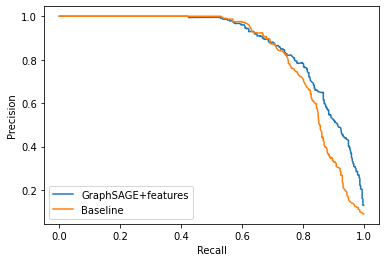

In [ ]:
num_samples = [2, 5]
embedding_node_type = "transaction"

hinsage = HinSAGE_Representation_Learner_Memory_Time_Weighted(embedding_size=64, num_samples=num_samples, 
                                                              embedding_for_node_type=embedding_node_type, S=S_1, batch_size=5)

inductive_labels, baseline_predictions, predictions = train_and_evaluate(start_train_time_step=0, end_train_time_step=30, 
                                                                         start_test_time_step=31, end_test_time_step=40, epochs=3)

## 2.1 Train and evaluate the model on the second time step



Epoch 1/3
14653/14653 [==============================] - 1523s 104ms/step - loss: 0.0299 - val_loss: 0.0230
Epoch 2/3
14653/14653 [==============================] - 1516s 103ms/step - loss: 0.0266 - val_loss: 0.0184
Epoch 3/3
6436/6436 [==============================] - 697s 108ms/step
Average precision-recall score XGBoost: 0.8456640256
Average precision-recall score XGBoost: 0.7914412412


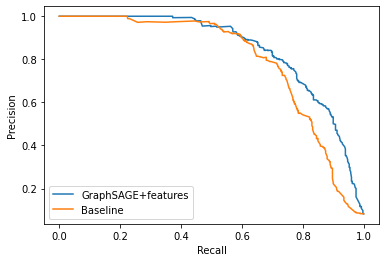

In [ ]:
inductive_labels, baseline_predictions, predictions = train_and_evaluate(start_train_time_step=31, end_train_time_step=60, 
                                                                         start_test_time_step=61, end_test_time_step=70, epochs=3)

## 2.2 Train the model on third time step

Epoch 1/3
15833/15833 [==============================] - 1767s 112ms/step - loss: 0.0283 - val_loss: 0.0219
Epoch 2/3
15833/15833 [==============================] - 1777s 112ms/step - loss: 0.0254 - val_loss: 0.0133
Epoch 3/3
6864/6864 [==============================] - 841s 123ms/step
Average precision-recall score XGBoost: 0.8404919906
Average precision-recall score XGBoost: 0.7847471084


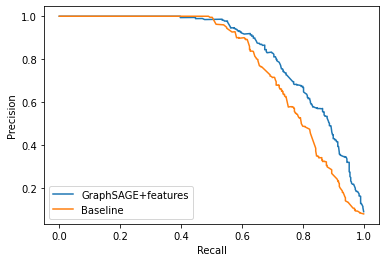

In [ ]:
inductive_labels, baseline_predictions, predictions = train_and_evaluate(start_train_time_step=61, end_train_time_step=90, 
                                                                         start_test_time_step=91, end_test_time_step=100, epochs=3)

# 3 Train and evealuate the models independently on each time step

Initialise the model and then run train and evaluate  for each time step to compare to those trained sequentially.

Epoch 1/5


/content/drive/MyDrive/stellargraph/data/explorer.py:1499: RuntimeWarning: invalid value encountered in true_divide
  samples = rs.choices(neigh_et, weights=neigh_et_steps/sum(neigh_et_steps), k=n_size[depth - 1])


13340/13340 [==============================] - 1433s 107ms/step - loss: 0.0647 - val_loss: 0.0463
Epoch 2/5
13340/13340 [==============================] - 1424s 107ms/step - loss: 0.0319 - val_loss: 0.0241
Epoch 3/5
13340/13340 [==============================] - 1423s 107ms/step - loss: 0.0286 - val_loss: 0.0270
Epoch 4/5
13340/13340 [==============================] - 1429s 107ms/step - loss: 0.0269 - val_loss: 0.0481
Epoch 5/5
5953/5953 [==============================] - 636s 107ms/step
Average precision-recall score XGBoost: 0.8741872573
Average precision-recall score XGBoost: 0.8420009173


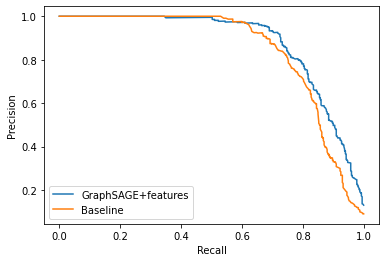

In [ ]:
num_samples = [2, 5]
embedding_node_type = "transaction"

hinsage = HinSAGE_Representation_Learner_Memory_Time_Weighted(embedding_size=64, num_samples=num_samples, embedding_for_node_type=embedding_node_type, S=S_1,
                                                batch_size=5)

inductive_labels, baseline_predictions, predictions = train_and_evaluate(start_train_time_step=0, end_train_time_step=30, 
                                                                         start_test_time_step=31, end_test_time_step=40, epochs=5)

## 3.1 Train and evaluate the model on the second time step



In [ ]:
hinsage = HinSAGE_Representation_Learner_Memory_Time_Weighted(embedding_size=64, num_samples=num_samples, embedding_for_node_type=embedding_node_type, S=S_1,
                                                batch_size=5)

inductive_labels, baseline_predictions, predictions = train_and_evaluate(start_train_time_step=31, end_train_time_step=60, 
                                                                         start_test_time_step=61, end_test_time_step=70, epochs=5)

## 3.2 Train the model on third time step

In [ ]:
hinsage = HinSAGE_Representation_Learner_Memory_Time_Weighted(embedding_size=64, num_samples=num_samples, embedding_for_node_type=embedding_node_type, S=S_1,
                                                batch_size=5)

inductive_labels, baseline_predictions, predictions = train_and_evaluate(start_train_time_step=61, end_train_time_step=90, 
                                                                         start_test_time_step=91, end_test_time_step=100, epochs=5)

# 4 Confusion Matrices

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("Baseline:")
ConfusionMatrixDisplay.from_predictions(inductive_labels, np.argmax(baseline_predictions, axis=1))
print("Precision:", precision_score(inductive_labels, np.argmax(baseline_predictions, axis=1)))
print("Recall:", recall_score(inductive_labels, np.argmax(baseline_predictions, axis=1)))

print("GraphSAGE:")
ConfusionMatrixDisplay.from_predictions(inductive_labels, np.argmax(predictions, axis=1))
print("Precision:", precision_score(inductive_labels, np.argmax(predictions, axis=1)))
print("Recall:", recall_score(inductive_labels, np.argmax(predictions, axis=1)))

In [ ]:
def classify_probabilities(prediction_probs, decision_boundary):
  pred_c = []
  for p in prediction_probs:
    if p > decision_boundary:
      pred_c.append(1)
    else:
      pred_c.append(0)
  return pred_c

print("Baseline")
baseline_pred_c = classify_probabilities(baseline_predictions[:, 1], 0.3)
ConfusionMatrixDisplay.from_predictions(inductive_labels, baseline_pred_c)
print("Precision:", precision_score(inductive_labels, baseline_pred_c))
print("Recall:", recall_score(inductive_labels, baseline_pred_c))

print()
print("GraphSAGE")
pred_c = classify_probabilities(predictions[:, 1], 0.23)
ConfusionMatrixDisplay.from_predictions(inductive_labels, pred_c)
print("Precision:", precision_score(inductive_labels, pred_c))
print("Recall:", recall_score(inductive_labels, pred_c))